In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

#from sim_handling import Simulation,loadSim #uses ds7
from sim_handling2 import Simulation,loadSim #ds8: faster, more space efficient
from diffusionstuff8 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

#set figsize to be big (12,12) inches
#rcParams['figure.figsize'] = 10,10

In [3]:
#set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (200,600), method='RK45')

#try a noisy simulation
test_2d_asym.noisy_init = False

#test_2d_asym.float_params['DoverdeltaX2'] *= 2 
test_2d_asym.layermax = 4000
#test_2d_asym.sigmastepmax= -0.01 #ablation
test_2d_asym.sigmastepmax= 0.3 #growth
test_2d_asym.center_reduction = 0.1
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

In [4]:
#create 1d sim (same args as 2d) and graph number of steps over time
ss_1d = Simulation(f1d, (test_2d_asym.shape[0],), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

ss_1d.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
ss_1d.layermax = test_2d_asym.layermax * 1.5 #make sure it reaches steady state
ss_1d.sigmastepmax = test_2d_asym.sigmastepmax 
ss_1d.sigma0 = test_2d_asym.sigma0
ss_1d.center_reduction = test_2d_asym.center_reduction
ss_1d.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
ss_1d.noisy_init = test_2d_asym.noisy_init

breaking because reached max number of layers grown


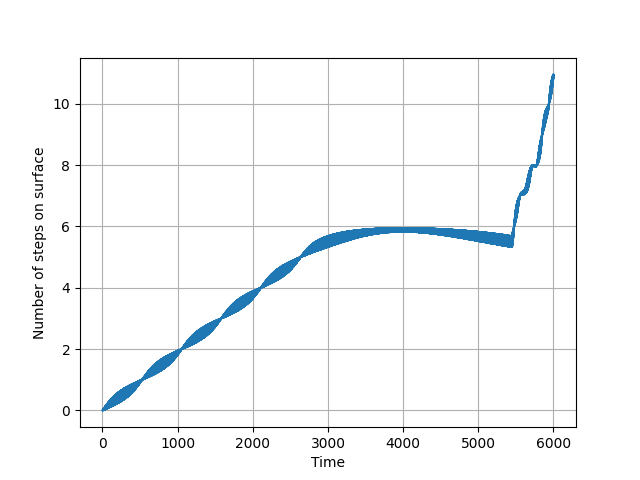

In [5]:
#print number of steps over time
Ntot = ss_1d.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

#ax.plot(test_f2d_sim.results()['t'],maxes-mins)
ax.plot(Ntot[:,0],maxes-mins)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()

ValueError: operands could not be broadcast together with shapes (28684,) (28683,) 

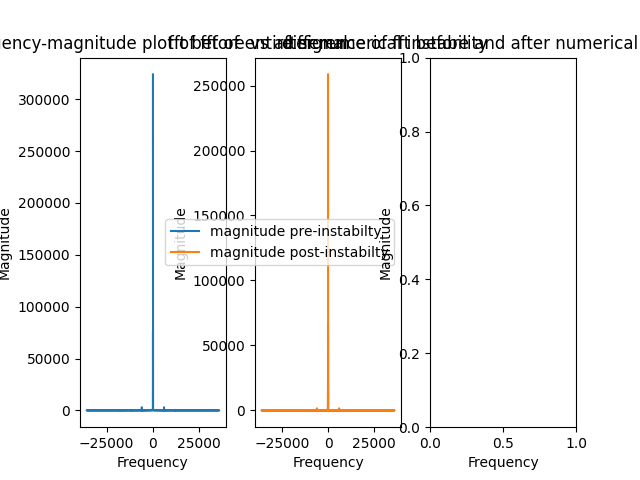

In [6]:
#plt.close()
#fourier analysis

xs = Ntot[:,0]
ys = maxes-mins
ys_fft = np.fft.fft(ys)
freq = np.fft.fftfreq(xs.shape[-1])


#plot the fft
#plt.figure('Real and imaginary parts of FFT in freq domain')
plt.figure('fft frequency-magnitude plots of #steps on ice surface over time')
#ax = plt.axes()
ax = plt.subplot(131)
#ax.plot(freq, ys_fft.real, label='real')
#ax.plot(freq, ys_fft.imag, label='imaginary')

#ax.plot(freq, np.sqrt(ys_fft.real**2 + ys_fft.imag**2), label='magnitude')
ax.set_title('frequency-magnitude plot of fft of entire signal')
ax.plot(list(map(lambda x: x*len(freq),freq)), np.sqrt(ys_fft.real**2 + ys_fft.imag**2), label='magnitude')

#ax.plot(freq, np.abs(ys_fft), label='magnitude')
#ax.stem(freq, np.abs(ys_fft), 'b', \
#         markerfmt=" ", basefmt="-b",label='magnitude')

ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')


ax = plt.subplot(132)
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')
#ax.set_title('fft before numerical instability')
#plot the fft of just the part before numerical instability\
cutpoint = int(len(ys)*2/5)
ys_pre_num = ys[:cutpoint]
xs_pre_num = xs[:cutpoint]
ys_fft_pre_num = np.fft.fft(ys_pre_num)
freq_pre_num = np.fft.fftfreq(xs_pre_num.shape[-1])
pre = np.sqrt(ys_fft_pre_num.real**2 + ys_fft_pre_num.imag**2)
ax.plot(list(map(lambda x: x*len(freq),freq_pre_num)), pre, label='magnitude pre-instabilty')

#ax = plt.subplot(123)
#ax.set_xlabel('Frequency')
#ax.set_ylabel('Magnitude')
#ax.set_title('fft after numerical instability')
ax.set_title('fft before vs after numerical instability')
#plot the fft of just the part AFTER numerical instability
cutpoint = int(len(ys)*2/5)
ys_post_num = ys[cutpoint:]
xs_post_num = xs[cutpoint:]
ys_fft_post_num = np.fft.fft(ys_post_num)
freq_post_num = np.fft.fftfreq(xs_post_num.shape[-1])
post = np.sqrt(ys_fft_post_num.real**2 + ys_fft_post_num.imag**2)
ax.plot(list(map(lambda x: x*len(freq),freq_post_num)), post, label='magnitude post-instabilty')
ax.legend()

#plot difference of pre and post plots
ax = plt.subplot(133)
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')
ax.set_title('difference of fft before and after numerical instability')
cut = int((len(post)-len(pre))//2)
ax.plot(list(map(lambda x: x*len(freq),freq_pre_num)), post[cut:-cut] - pre)

#NOTE idea: scale pre to post based off magnitude of zero peak so when subtracting, just the new frequencies of the numerical instability are shown (and not base/natural frequencies)

#plot the fft with high frequencies filtered out
# ys_fft_filtered = ys_fft.copy()
# ys_fft_filtered[np.abs(freq) > 0.1] = 0
# ax.plot(freq, np.abs(ys_fft_filtered), label='magnitude filtered')

#ax.stem(freq, np.abs(ys_fft_filtered), 'r', \
#         markerfmt=" ", basefmt="-r",label='magnitude filtered')



In [ ]:
# #fourier analysis filtered to remove lowest freq signals
# #plt.close()

# xs = Ntot[:,0]
# ys = maxes-mins
# ys_fft = np.fft.fft(ys)
# ys_fft_filtered = ys_fft.copy()
# freq = np.fft.fftfreq(xs.shape[-1])
# ys_fft_filtered[np.abs(freq) < 600] = 30 # removes lowest frequency noise


# #plot the fft
# #plt.figure('Real and imaginary parts of FFT in freq domain')
# plt.figure('fft frequency-magnitude plots of #steps on ice surface over time')
# ax = plt.subplot(131)
# ax.set_title('frequency-magnitude plot of fft of entire signal')
# ax.plot(list(map(lambda x: x*len(freq),freq)), np.sqrt(ys_fft_filtered.real**2 + ys_fft_filtered.imag**2), label='magnitude')
# ax.set_xlabel('Frequency')
# ax.set_ylabel('Magnitude')


# ax = plt.subplot(132)
# ax.set_title('fft before vs after numerical instability')
# ax.set_xlabel('Frequency')
# ax.set_ylabel('Magnitude')
# #ax.set_title('fft before numerical instability')
# #plot the fft of just the part before numerical instability\
# cutpoint = int(len(ys)*2/5)
# ys_pre_num = ys[:cutpoint]
# xs_pre_num = xs[:cutpoint]
# ys_fft_pre_num = np.fft.fft(ys_pre_num)
# freq_pre_num = np.fft.fftfreq(xs_pre_num.shape[-1])
# ys_fft_pre_num_filtered = ys_fft_pre_num.copy()
# ys_fft_pre_num_filtered[np.abs(freq_pre_num) < 600] = 30 # removes lowest frequency noise

# pre = np.sqrt(ys_fft_pre_num_filtered.real**2 + ys_fft_pre_num_filtered.imag**2)
# ax.plot(list(map(lambda x: x*len(freq),freq_pre_num)), pre, label='magnitude pre-instabilty')

# #plot the fft of just the part AFTER numerical instability
# cutpoint = int(len(ys)*2/5)
# ys_post_num = ys[cutpoint:]
# xs_post_num = xs[cutpoint:]
# ys_fft_post_num = np.fft.fft(ys_post_num)
# freq_post_num = np.fft.fftfreq(xs_post_num.shape[-1])
# ys_fft_post_num_filtered = ys_fft_post_num.copy()
# ys_fft_post_num_filtered[np.abs(freq_post_num) < 600] = 30 # removes lowest frequency noise

# post = np.sqrt(ys_fft_post_num_filtered.real**2 + ys_fft_post_num_filtered.imag**2)
# ax.plot(list(map(lambda x: x*len(freq),freq_post_num)), post, label='magnitude post-instabilty')
# ax.legend()

# #plot difference of pre and post plots
# ax = plt.subplot(133)
# ax.set_xlabel('Frequency')
# ax.set_ylabel('Magnitude')
# ax.set_title('difference of fft before and after numerical instability')
# cut = int((len(post)-len(pre))//2)
# ax.plot(list(map(lambda x: x*len(freq),freq_pre_num)), post[cut:-cut] - pre)

# #NOTE idea: scale pre to post based off magnitude of zero peak so when subtracting, just the new frequencies of the numerical instability are shown (and not base/natural frequencies)

# #plot the fft with high frequencies filtered out
# # ys_fft_filtered = ys_fft.copy()
# # ys_fft_filtered[np.abs(freq) > 0.1] = 0
# # ax.plot(freq, np.abs(ys_fft_filtered), label='magnitude filtered')

# #ax.stem(freq, np.abs(ys_fft_filtered), 'r', \
# #         markerfmt=" ", basefmt="-r",label='magnitude filtered')



In [ ]:
#calculate dominant frequencies

num_largest_signals = 40
num_decimals_to_round_to = 1
#fft pre_num
#code explained: get the frequencies of the largest signals, only keep unique magnitudes, rounded to nearest 10th scaled by len(freq) to get the actual frequency (units of inverse timestep)
dominant_freqs_pre_num = list(set(map(lambda x: round(x,num_decimals_to_round_to) ,np.abs(freq[np.argsort(np.abs(ys_fft_pre_num))[-num_largest_signals:]])*len(freq))))
#fft post_num
dominant_freqs_post_num = list(set(map(lambda x: round(x,num_decimals_to_round_to) ,np.abs(freq[np.argsort(np.abs(ys_fft_post_num))[-num_largest_signals:]])*len(freq))))
#fft all
dominant_freqs = list(set(map(lambda x: round(x,num_decimals_to_round_to) ,np.abs(freq[np.argsort(np.abs(ys_fft))[-num_largest_signals:]])*len(freq))))

print('Dominant frequencies:', *dominant_freqs)
print('Dominant frequencies pre-numerical instability:', *dominant_freqs_pre_num)
print('Dominant frequencies post-numerical instability:', *dominant_freqs_post_num)
print('Frequencies that appear in pre and post:', *list(set(dominant_freqs_pre_num).intersection(dominant_freqs_post_num)))
print('Dominant freqs. in pre but not post: ', *list(set(dominant_freqs_pre_num).difference(dominant_freqs_post_num)))
print('Dominant freqs. in post but not pre: ', *list(set(dominant_freqs_post_num).difference(dominant_freqs_pre_num)))

Dominant frequencies: 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 1496.0 1498.0 1499.0 1500.0
Dominant frequencies pre-numerical instability: 0.0 1.0 2.0 10115.0 10116.0 10117.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 3.0 4.0 5.0 10699.0 10700.0 10701.0 10702.0 10703.0 10704.0 10705.0 10706.0 10707.0 10708.0 10709.0 598.0 599.0 10710.0 10711.0 600.0 10712.0 10713.0 10714.0
Dominant frequencies post-numerical instability: 0.0 897.0 898.0 899.0 900.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 3.0 2.0 4.0 10716.0 1.0 10717.0 10718.0 10719.0 11612.0 11613.0 11614.0 11615.0 10720.0 10721.0 10722.0 10723.0 10724.0 10725.0 10726.0 10727.0 10728.0 10729.0 10730.0 10731.0
Frequencies that appear in pre and post: 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0
Dominant freqs. in pre but not post:  10115.0 10116.0 10117.0 16.0 17.0 10699.0 10700.0 10701.0 10702.0 10703.0 10704.0 10705.0 10706.0 10707.0 10708.0 10709.0 598

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'f(x)')

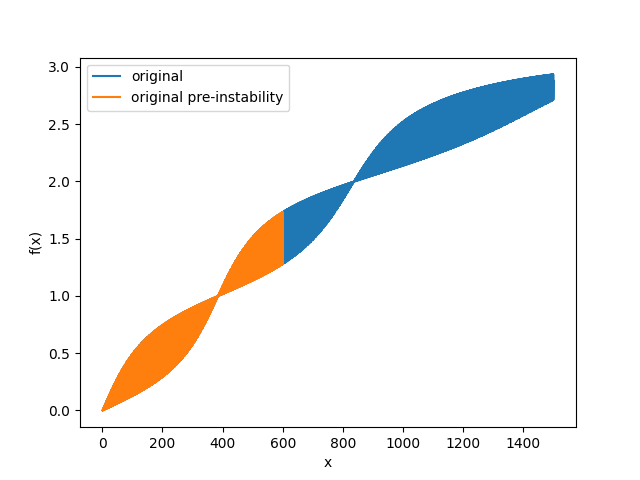

In [ ]:
#plot the signals reconstructed from fft
plt.figure('reconstructed signal')
ax = plt.axes()
ax.plot(xs, np.fft.ifft(ys_fft), label='original')  
ax.plot(xs_pre_num, np.fft.ifft(ys_fft_pre_num), label='original pre-instability')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (0, 100) and arg 2 with shape (0, 200).

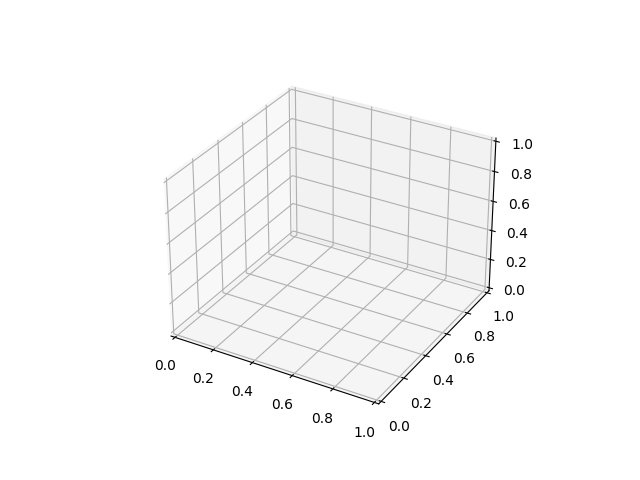

In [ ]:
plt.figure('1d surface over time as 3d plot')
#plot 1d surface over time as 3d plot
Ntot = ss_1d.getNtot()
ax = plt.axes(projection='3d')
#start and stop points in time
startpoint = int(len(Ntot)*5)
cutpoint = int(len(Ntot)*2/5)
xs, ys = np.meshgrid(np.linspace(0,50,100), Ntot[startpoint:cutpoint,0])
ax.plot_surface(xs,ys, Ntot[startpoint:cutpoint,:])

number of timesteps in Ntots 69935


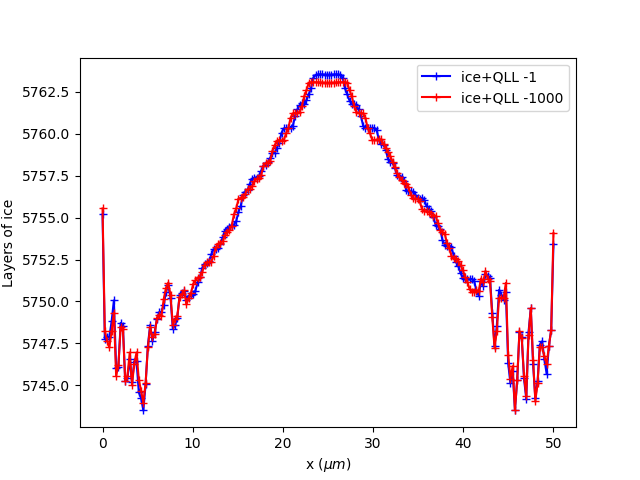

In [ ]:
plt.close()
plt.figure('sample 1d surface')
ax = plt.axes()
Ntots = ss_1d.getNtot()
print('number of timesteps in Ntots',len(Ntots))
ax.plot(ss_1d.x, Ntots[-1] - (np.mean(Ntots[-1]-Ntots[-1000])), 'b-+', label='ice+QLL -1')
ax.plot(ss_1d.x, Ntots[-1000], 'r-+', label='ice+QLL -1000')
ax.set_xlabel(r'x ($\mu m$)')
ax.set_ylabel('Layers of ice')
ax.legend()